# Bollinger Bands Trading Strategy

Bollinger bands consist of 3 lines that are plotted around the movements of a security:
1. A moving average (MA), this is the middle band
2. An upper band that is 2 standard deviations above the MA
3. A lower band that is 2 standard deviations below the MA

These upper and lower bands capture the volatility in the stock. They are able to tell us a few different things:

1. If the price is at or above the upper band, it might be overbought and could go down very soon
2. If the price is at or below the lower band, it might be oversold and could go up very soon
3. If the bands get closer together, a squeeze, it means a period of low volatility and could mean the price could soon change significantly
4. A breakout of a upper or lower band might mean that the price will continue this trend

In [136]:
# Necessary libraries
import numpy as np 
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt

In [334]:
# Get historical data 
symbol = 'AAPL' 
start_date = '2018-01-01'
end_date = '2025-3-31'
data = yf.Ticker(symbol) 
df = data.history(period='1d', start=start_date, end=end_date)
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-24 00:00:00-04:00,220.710569,221.189936,218.293740,220.440918,44299500,0.0,0.0
2025-03-25 00:00:00-04:00,220.480877,223.806518,219.791778,223.456970,34493600,0.0,0.0
2025-03-26 00:00:00-04:00,223.217271,224.725303,220.181259,221.239868,34466100,0.0,0.0
2025-03-27 00:00:00-04:00,221.100054,224.695345,220.271139,223.556839,37094800,0.0,0.0
2025-03-28 00:00:00-04:00,221.379691,223.516888,217.394911,217.614624,39818600,0.0,0.0


## Calculate Bands

In [337]:
df['MA_20'] = df['Close'].rolling(window=20).mean() # 20 day moving average
df['STD_20'] = df['Close'].rolling(window=20).std() # 20 day moving standard deviation
df['Upper Band'] = df['MA_20'] + (df['STD_20'] * 2)
df['Lower Band'] = df['MA_20'] - (df['STD_20'] * 2)

# More moving averages
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_100'] = df['Close'].rolling(window=100).mean()


## Plot Bollinger Bands and moving average

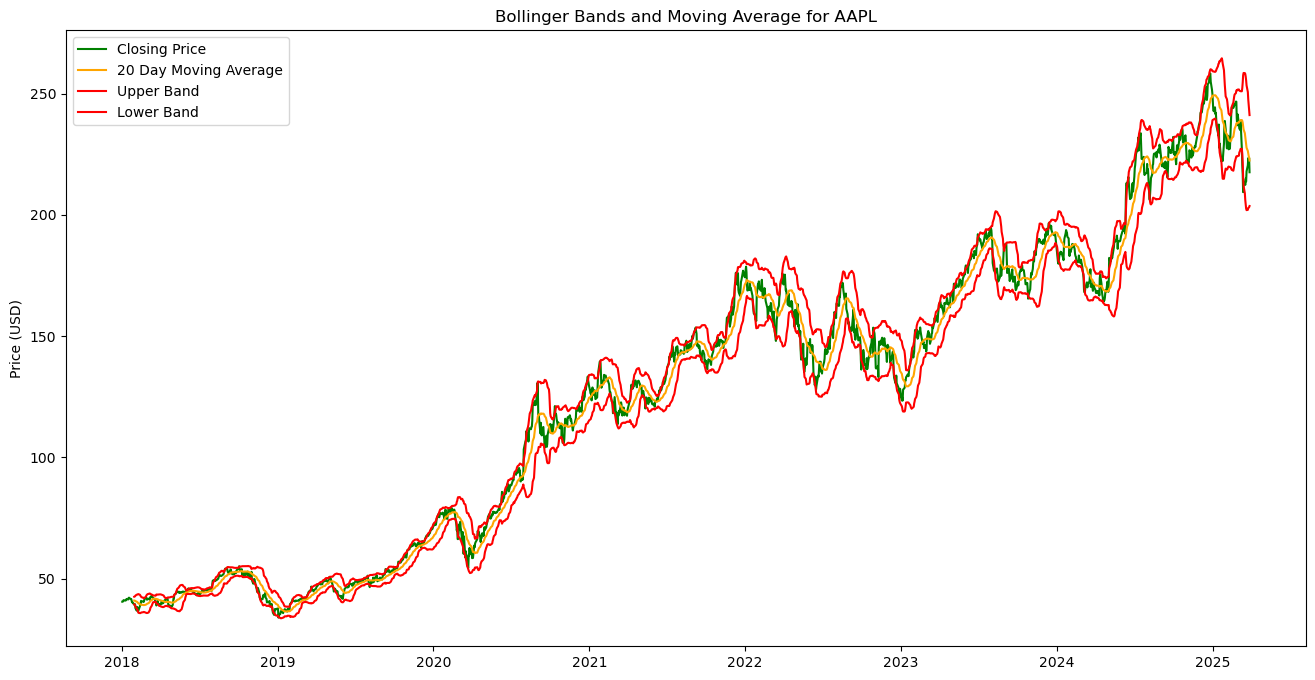

In [340]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label="Closing Price", color='green')
plt.plot(df['MA_20'], label="20 Day Moving Average", color='orange')
plt.plot(df['Upper Band'], label="Upper Band", color='red')
plt.plot(df['Lower Band'], label="Lower Band", color='red')
plt.title('Bollinger Bands and Moving Average for ' + symbol)
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## Trading Strategy
Add a buy and a sell signal that will buy when the price is at the lower band and sell when price is at the upper band
Also, use the 50 and 10 day moving averages and only buy if the 10 day MA is above the 50 day MA

In [342]:
capital = 100000 # initial capital

df['Signal'] = 0
df['Buy_Signal'] = ((df['Close'] < df['Lower Band']) & (df['MA_10'] > df['MA_50'])).astype(int)
df['Sell_Signal'] = (df['Close'] > df['Upper Band']).astype(int)

# New dataframes for the positions and holdings
positions = pd.DataFrame(index=df.index).fillna(0)
holdings = pd.DataFrame(index=df.index).fillna(0.0)

positions['Holdings'] = 100*df['Buy_Signal'] # Buy 100 shares
positions['Holdings'] = positions['Holdings'] - 100*df['Sell_Signal'] # Sell all shares

positions['Holdings'] = positions['Holdings'].clip(lower=0)

holdings['Holdings'] = positions.multiply(df['Close'], axis=0)
pos_diff = positions.diff()
portfolio = holdings
portfolio['Cash'] = capital - (pos_diff.multiply(df['Close'], axis=0)).cumsum()
portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']
portfolio['Returns'] = portfolio['Total'].pct_change()



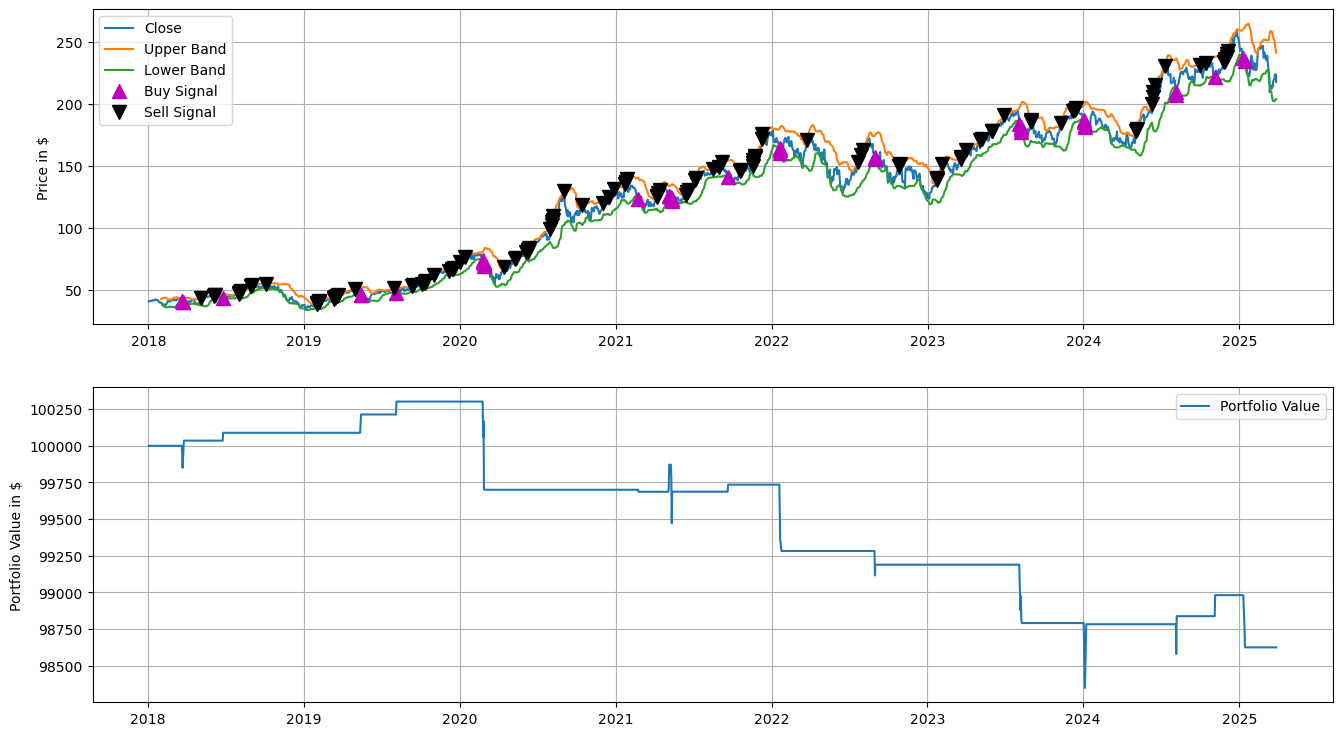

In [345]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 9))

for c in ['Close', 'Upper Band', 'Lower Band']:
    ax1.plot(df.index, df[c], label=c)
ax1.plot(df.loc[df['Buy_Signal'] == 1].index, df.loc[df['Buy_Signal'] == 1]['Lower Band'], '^', markersize=10, color='m', label='Buy Signal')
ax1.plot(df.loc[df['Sell_Signal'] == 1].index, df.loc[df['Sell_Signal'] == 1]['Upper Band'], 'v', markersize=10, color='k', label='Sell Signal')
ax1.set_ylabel('Price in $')
ax1.legend(loc='best')
ax1.grid()

ax2.plot(portfolio.index, portfolio['Total'], label='Portfolio Value')
ax2.set_ylabel('Portfolio Value in $')
ax2.legend(loc='best')
ax2.grid()

plt.show()
     